Treatment depends on covariates, causing **selection bias**.

Here, randomness with probability assignment brings forth the bias.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

np.random.seed(42)
data = pd.DataFrame({
    'age': np.random.normal(50, 10, 1000),   
    'income': np.random.normal(50000, 15000, 1000),  
    'treatment': np.random.choice([0, 1], size=1000, p=[0.6, 0.4]),  
    'outcome': np.random.normal(10, 5, 1000)  
})

print(data.head())


         age        income  treatment    outcome
0  54.967142  70990.331549          0  12.865639
1  48.617357  63869.505244          0   1.070668
2  56.476885  50894.455549          0   8.201852
3  65.230299  40295.948334          0  11.505537
4  47.658466  60473.349704          1  10.919173


Propensity score is the probability of receiving treatment `(treatment=1)` given the covariates (`age` and `income`).

Unlike matching on all covariates, PSM (Propensity Score Matching) reduces the matching problem to a single scalar (propensity score). 

## Propensity Score

The propensity score (PS) is the probability of receiving treatment (T=1) given a set of covariates $(X_1, X_2, ..., X_k)$ using logistic regression. 

$PS(X) = P(T=1|X) = \frac{\exp(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_kX_k)}{1 + \exp(+\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_kX_k)}$

where, 

T = Treatment assignment \
$X_1, X_2, ... X_k$ = Covariates affecting treatment probability \
$\beta_0, \beta_1, ..., \beta_k$ = Regression coefficients estimated by logistic regression

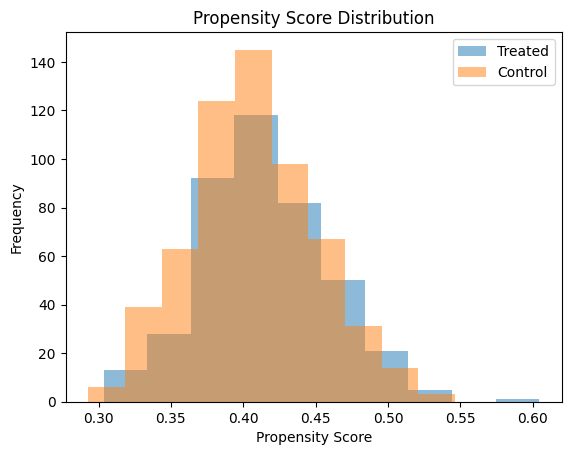

In [9]:
# Logistic regression for propensity scores
covariates = ['age', 'income']
log_reg = LogisticRegression()

# fitting logistic regression
# data['treatment'] is the dependent variable, covariates are independent
# predict_proba(data[covariates]) computes predicted probabilities 
# of each individual having T=0 and T=1

# propensity score is for probability of having treatment=1
# so [:, 1] extracts probability of being in treatment group (T=1)
data['propensity_score'] = log_reg.fit(data[covariates],
                                       data['treatment']).predict_proba(
                                        data[covariates])[:, 1]

plt.hist(data[data['treatment'] == 1]['propensity_score'], alpha=0.5, label='Treated')
plt.hist(data[data['treatment'] == 0]['propensity_score'], alpha=0.5, label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Propensity Score Distribution')
plt.legend()
plt.show()


The histogram shows the distribution of propensity scores for treated and control groups. Ideally, there should be overlap between these distributions to ensure comparability. 

- Treated group typically has higher propensity scores.
- Control group typically has lower propensity scores.
- Overlap between the distributions is essential for effective matching.

Overlap ensures that for every treated individual, we can find a control individual with a similar propensity score.

Violation of Overlap (Positivity): If no overlap exists, we cannot compare outcomes in certain regions, leading to biased results.


### Nearest-Neighbor Matching

For each treated individual, find the control individual with the closest propensity score (nearest-neighbor matching).

We pair these individuals to create a matched dataset.

In [4]:
treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

# Match treated and control based on propensity score
distances = pairwise_distances(treated[['propensity_score']], control[['propensity_score']], metric='euclidean')
matched_idx = distances.argmin(axis=1)

matched_control = control.iloc[matched_idx]
matched_data = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)])


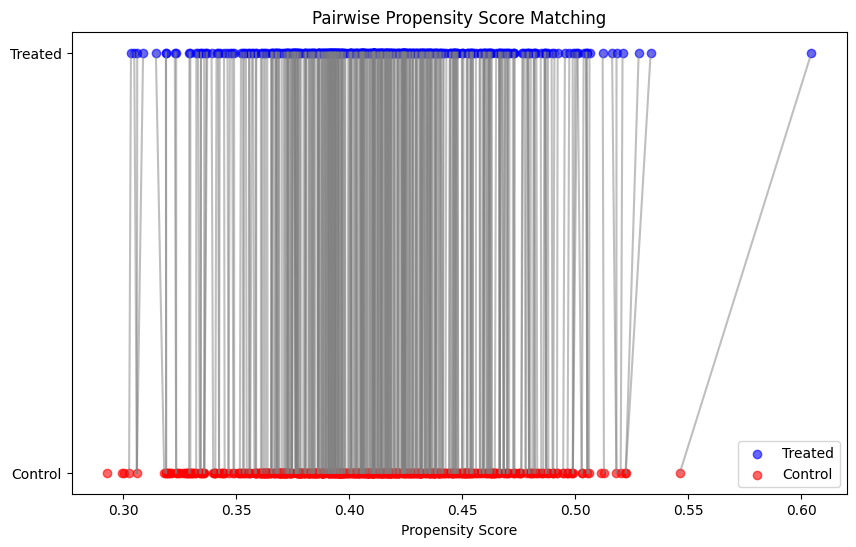

In [5]:
# Pairwise matching visualization
plt.figure(figsize=(10, 6))
plt.scatter(treated['propensity_score'], [1] * len(treated), color='blue', alpha=0.6, label='Treated')
plt.scatter(control['propensity_score'], [0] * len(control), color='red', alpha=0.6, label='Control')

# Lines to indicate matches
for i, control_idx in enumerate(matched_idx):
    plt.plot([treated.iloc[i]['propensity_score'], control.iloc[control_idx]['propensity_score']], [1, 0], 'gray', alpha=0.5)

plt.xlabel('Propensity Score')
plt.yticks([0, 1], ['Control', 'Treated'])
plt.title('Pairwise Propensity Score Matching')
plt.legend()
plt.show()


In [6]:
# Matched indices
matched_treated_indices = treated.index
matched_control_indices = control.iloc[matched_idx].index

# Discarded indices
discarded_treated_indices = treated.index.difference(matched_treated_indices)
discarded_control_indices = control.index.difference(matched_control_indices)

print(f"Number of Discarded Treated Points: {len(discarded_treated_indices)}")
print(f"Number of Discarded Control Points: {len(discarded_control_indices)}")

# Display discarded data
discarded_treated = treated.loc[discarded_treated_indices]
discarded_control = control.loc[discarded_control_indices]
print("Discarded Treated Data:")
print(discarded_treated)
print("\nDiscarded Control Data:")
print(discarded_control)


Number of Discarded Treated Points: 0
Number of Discarded Control Points: 325
Discarded Treated Data:
Empty DataFrame
Columns: [age, income, treatment, outcome, propensity_score]
Index: []

Discarded Control Data:
           age        income  treatment    outcome  propensity_score
0    54.967142  70990.331549          0  12.865639          0.456337
1    48.617357  63869.505244          0   1.070668          0.420066
3    65.230299  40295.948334          0  11.505537          0.457274
6    65.792128  63427.898300          0  11.749000          0.491685
9    55.425600  41971.471827          0   1.118768          0.418597
..         ...           ...        ...        ...               ...
985  38.416353  57696.281301          0   8.366519          0.370504
988  47.790358  40377.776072          0  12.321849          0.385311
994  39.983800  55271.723113          0  12.930829          0.373577
997  56.408429  36771.880232          0   8.796674          0.415632
999  55.725828  38826.46032

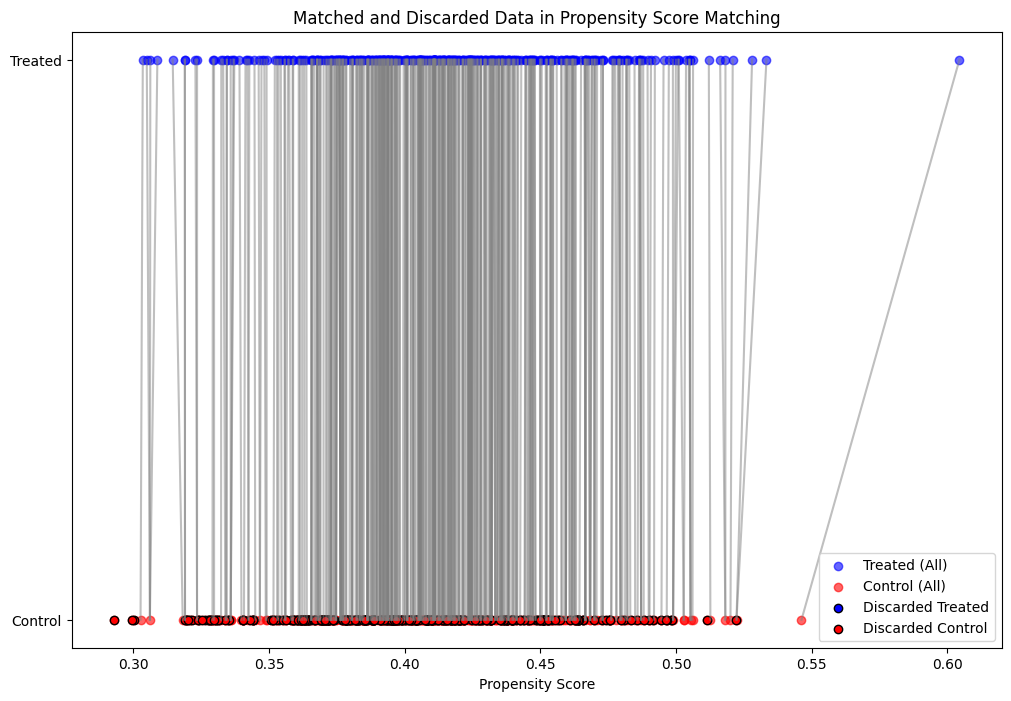

In [7]:
# Propensity score matching visualization with discarded points
plt.figure(figsize=(12, 8))
plt.scatter(treated['propensity_score'], [1] * len(treated), color='blue', alpha=0.6, label='Treated (All)')
plt.scatter(control['propensity_score'], [0] * len(control), color='red', alpha=0.6, label='Control (All)')

# Highlight discarded points
plt.scatter(discarded_treated['propensity_score'], [1] * len(discarded_treated), color='blue', edgecolor='black', label='Discarded Treated')
plt.scatter(discarded_control['propensity_score'], [0] * len(discarded_control), color='red', edgecolor='black', label='Discarded Control')

# Lines to indicate matches
for i, control_idx in enumerate(matched_idx):
    plt.plot([treated.iloc[i]['propensity_score'], control.iloc[control_idx]['propensity_score']], [1, 0], 'gray', alpha=0.5)

plt.xlabel('Propensity Score')
plt.yticks([0, 1], ['Control', 'Treated'])
plt.title('Matched and Discarded Data in Propensity Score Matching')
plt.legend()
plt.show()


#### Standardized Mean Difference

Measures the difference in covariate means between treated and control groups, scaled by their pooled standard deviation.

$SMD = \frac{\text{Mean}_\text{Treated} - \text{Mean}_\text{Control}}{\text{Pooled Std.}}$

$
\text{SMD} = \frac{\bar{X}_T - \bar{X}_C}{\sqrt{\frac{s_T^2 + s_C^2}{2}}}
$
Where, 

\begin{align*}
\bar{X}_T & : \text{Mean of covariate } X \text{ in the treated group.} \\
\bar{X}_C & : \text{Mean of covariate } X \text{ in the control group.} \\
s_T^2 & : \text{Variance of } X \text{ in the treated group.} \\
s_C^2 & : \text{Variance of } X \text{ in the control group.}
\end{align*}


In [7]:
def check_balance(group1, group2, covariates):
    balance = {}
    for cov in covariates:
        diff = group1[cov].mean() - group2[cov].mean()
        pooled_std = np.sqrt((group1[cov].std()**2 + group2[cov].std()**2) / 2)
        balance[cov] = diff / pooled_std  # Standardized mean difference
    return balance

balance_before = check_balance(treated, control, covariates)

balance_after = check_balance(treated, matched_control, covariates)

print("Balance Before Matching:", balance_before)
print("Balance After Matching:", balance_after)


Balance Before Matching: {'age': 0.16184545902033362, 'income': 0.07603002656656355}
Balance After Matching: {'age': 0.044866236725638164, 'income': -0.08097085012371502}


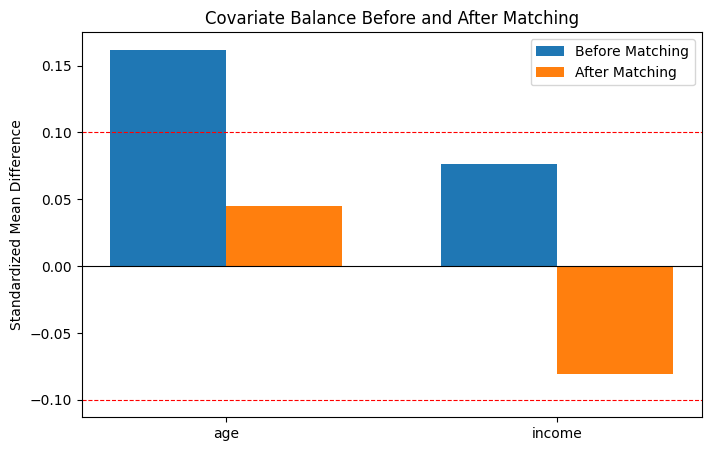

In [8]:
labels = covariates
before_values = list(balance_before.values())
after_values = list(balance_after.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, before_values, width, label='Before Matching')
rects2 = ax.bar(x + width/2, after_values, width, label='After Matching')

ax.set_ylabel('Standardized Mean Difference')
ax.set_title('Covariate Balance Before and After Matching')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(0, color='black', linewidth=0.8)
ax.axhline(0.1, color='red', linestyle='--', linewidth=0.8)
ax.axhline(-0.1, color='red', linestyle='--', linewidth=0.8)
ax.legend()
plt.show()


#### Large SMDs before matching highlight the confounding effect of covariates.
#### Reduced SMDs after matching confirm the success of propensity score matching in removing bias.

#### ATE without Matching

In [8]:
# naive ATE
treated_outcomes = treated['outcome']
control_outcomes = control['outcome']
naive_ate = treated_outcomes.mean() - control_outcomes.mean()

print(f"ATE Without Matching: {naive_ate:.2f}")

ATE Without Matching: 0.09


Direct comparison of outcomes likely overestimates or underestimates the treatment effect due to covariate imbalances.

In [9]:
# (ATE)
treated_outcomes = matched_data[matched_data['treatment'] == 1]['outcome']
control_outcomes = matched_data[matched_data['treatment'] == 0]['outcome']
ate = treated_outcomes.mean() - control_outcomes.mean()

print(f"Average Treatment Effect (ATE): {ate:.2f}")

Average Treatment Effect (ATE): 0.23


Matching balances covariates, providing a more accurate and unbiased estimate of the treatment effect.